In [1]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Tuple, Union
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====

assert MODEL_DEPTH in {16, 20, 24, 30, 36}
FIGURE_PATH = 'report/figures/'


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


/tmp/ipykernel_446305/1170292025.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
/tmp/ipykern

preparation finished.


In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.unit_mem import get_datasets
IMAGENET_PATH = '/home/woody/iwi1/iwi1106h/data/imagenet'

augs_per_img = 8
num_per_class = 32
num_classes = 256
random.seed(0)
classes = random.sample(range(1000), num_classes)
# each batch will be the same image with different augmentations
dataset, dataset_val = get_datasets(IMAGENET_PATH, num_per_class, classes, augs_per_img)
ds_by_index, ds_by_index_val = get_datasets(IMAGENET_PATH, num_per_class, classes, 1, no_crop=True)

ld_val = DataLoader(dataset_val, num_workers=0, batch_size=augs_per_img,)
ld = DataLoader(dataset, num_workers=0, batch_size=augs_per_img,)

In [3]:
from torch import LongTensor, Tensor
import re
import pandas as pd
from tqdm.notebook import tqdm
import os
activations = {}


# remove the handles if it crashed
if ('handles' in locals() or 'handles' in globals()) and handles:
    for h in handles:
        h.remove()

handles = []
for module_name, module in var.named_modules():
    if re.match(r'blocks\.\d{1,2}\.(attn\.proj$|ffn\.fc\d)', module_name):
        def hook_fn(module, input, output, name=module_name):
            if 'fc1' in name:
                output = torch.nn.functional.gelu(output, approximate='tanh')
            activations[name] = torch.abs(output)
        handles.append(module.register_forward_hook(hook_fn))

device = 'cuda'
batches = len(ld)
def get_data_for_loader(loader):
    activation_data = []
    for it, (inp_B3HW, label_B) in enumerate(tqdm(loader, total=batches, desc="Processing batches")):

        inp_B3HW = inp_B3HW.to(device)
        label_B = label_B.to(device)
        
        # from train_step
        B, V = label_B.shape[0], vae.vocab_size
        
        # it's actually gt_idx_lB (a list element per scale)
        gt_idx_Bl: List[LongTensor] = vae.img_to_idxBl(inp_B3HW)
        # gt does not get interpolated
        gt_BL = torch.cat(gt_idx_Bl, dim=1)
        # This does the interpolation from r1 to e1, r2 to e2, etc.
        # and the embedding (embeddings are 32dim)
        x_BLCv_wo_first_l: Tensor = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
        
        # This runs in teacher forcing mode (but we interpolated the input above)
        logits_BLV = var(label_B, x_BLCv_wo_first_l)
        #loss = self.train_loss(logits_BLV.view(-1, V), gt_BL.view(-1)).view(B, -1)
        #loss = loss.mul(lw).sum(dim=-1).mean()
        
        for name, activation in activations.items():
            activation_data.append({
                'image_id': it,
                'class': label_B[0].item() if label_B.ndim == 1 else label_B.item(),
                'layer_name': name,
                'activations': torch.mean(activation, dim=(0, 1)).cpu().numpy()
            })
        

    return pd.DataFrame(activation_data)


if os.path.exists("activation_df.pkl") and os.path.exists("activation_df_val.pkl"):
    print("Loading activation data from pickle files.")
    activation_df = pd.read_pickle("activation_df.pkl")
    activation_df_val = pd.read_pickle("activation_df_val.pkl")
    print("Loaded activation data from pickle files.")
else:
    print("Calculatating activation data.")
    activation_df = get_data_for_loader(ld)
    activation_df.to_pickle("activation_df.pkl")
    print("Calculated and safed activation data for training data")
    activation_df_val = get_data_for_loader(ld_val)
    activation_df_val.to_pickle("activation_df_val.pkl")
    print("Calculated and saved activation data for validation data.")


for handle in handles: handle.remove()

Calculatating activation data.


Processing batches:   0%|          | 0/8192 [00:00<?, ?it/s]

/home/woody/iwi1/iwi1106h/Projects/VAR-UnitMem/models/var.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Calculated and safed activation data for training data


Processing batches:   0%|          | 0/8192 [00:00<?, ?it/s]

Calculated and saved activation data for validation data.


In [22]:
def aggregate_data(data_to_agg, img_cnt):
    agg_data = data_to_agg.groupby('layer_name').agg(
        layer_name=('layer_name', 'first'),
        normal_mean=('activations', 'mean'), # sanity check
        mu_mean_no_max=('activations', lambda x: (np.stack(x).mean(axis=0) * img_cnt - np.stack(x).max(axis=0))/(img_cnt - 1)),
        count=('activations', 'size'), # sanity check
        mu_max=('activations', lambda x: np.stack(x).max(axis=0)),
        mu_argmax=('activations', lambda x: np.stack(x).argmax(axis=0)), # The image producing the max activation
    )

    agg_data['unit_mem'] = (agg_data['mu_max']-agg_data['mu_mean_no_max']) / (agg_data['mu_max'] + agg_data['mu_mean_no_max'])
    agg_data['avg_unit_mem'] = agg_data['unit_mem'].apply(lambda x: np.mean(x))
    agg_data['max_unit_mem'] = agg_data['unit_mem'].apply(lambda x: np.max(x))
    agg_data['layer_type'] = agg_data['layer_name'].str.extract(r'(attn.proj|ffn.fc1|ffn.fc2)$', expand=False)
    agg_data['layer_num'] = agg_data['layer_name'].apply(lambda x: int(re.search(r'blocks\.(\d{2})\.', x).group(1)) if re.search(r'blocks\.(\d{2})\.', x) else -1)

    all_unit_mems = np.concatenate(agg_data['unit_mem'].to_numpy())
    # calculate the 90th percentile
    ninety_percentile = np.percentile(all_unit_mems, 90)

    agg_data['top_10_percentile_mask'] = agg_data['unit_mem'].apply(lambda x: x >= ninety_percentile)
    agg_data['top_10_percentile_values'] = agg_data['unit_mem'].apply(lambda x: x[x >= ninety_percentile])
    agg_data['top_10_percentile_count'] = agg_data['top_10_percentile_values'].apply(lambda x: len(x))
    agg_data['top_10_percentile_mu_argmax'] = [
        np.array(mu_argmax)[mask]
        for mu_argmax, mask in zip(agg_data['mu_argmax'], agg_data['top_10_percentile_mask'])
    ]
    return agg_data

In [52]:
activation_df['layer_name'] = activation_df['layer_name'].apply(lambda x: re.sub(r'blocks\.(\d{1})\.', r'blocks.0\1.', x))
activation_df['ds'] = 'train'

activation_df_val['layer_name'] = activation_df_val['layer_name'].apply(lambda x: re.sub(r'blocks\.(\d{1})\.', r'blocks.0\1.', x))
activation_df_val['ds'] = 'val'

data_to_agg = activation_df
img_cnt = num_classes * num_per_class

agg_data = aggregate_data(data_to_agg, img_cnt)

8190 8185
98304 9831
5798


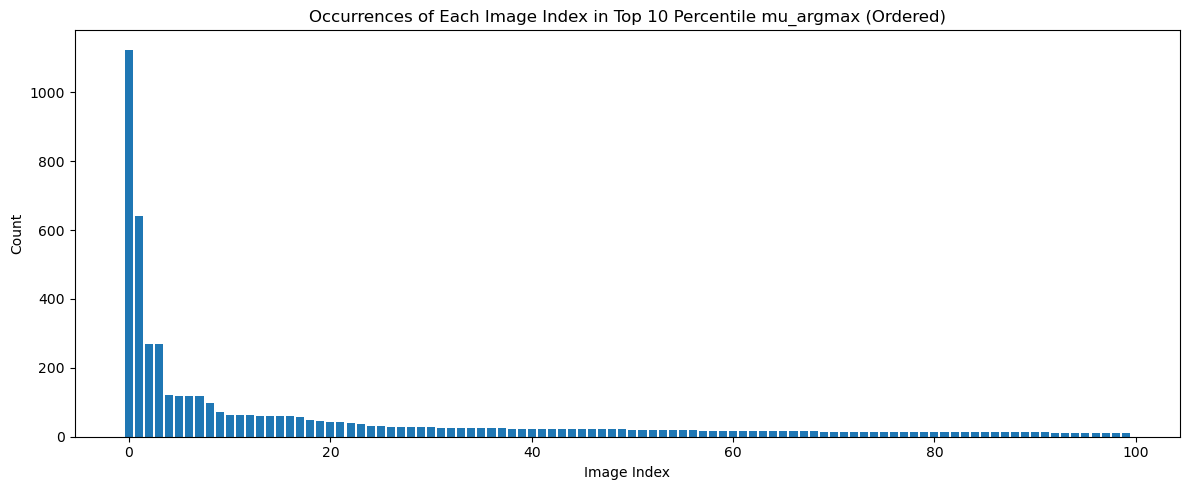

27.19% of images appear at least once in the top 10 percentile (2227/8192).
Top 1% (81/8192) cover 49.28% (4845/9831) of all top 10 percentile occurrences.
Top 5% (409/8192) cover 70.92% (6972/9831) of all top 10 percentile occurrences.
Top 10% (819/8192) cover 82.77% (8137/9831) of all top 10 percentile occurrences.


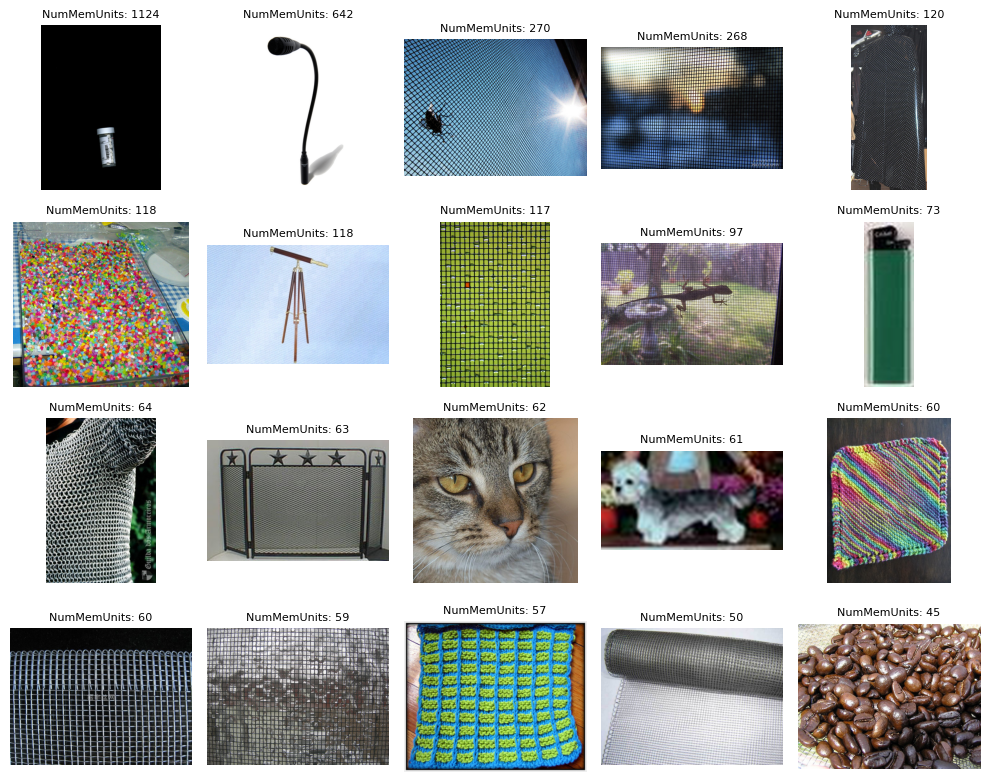

In [24]:
import collections

mu_argmax_values = np.concatenate(agg_data['mu_argmax'].values)
mu_argmax_values_top_10 = np.concatenate(agg_data['top_10_percentile_mu_argmax'].values)
print(max(mu_argmax_values), max(mu_argmax_values_top_10))
print(len(mu_argmax_values), len(mu_argmax_values_top_10))

value_counts = collections.Counter(mu_argmax_values)
print(len(value_counts))
value_counts_top_10 = collections.Counter(mu_argmax_values_top_10)
# Order by count descending
ordered = value_counts_top_10.most_common()
values, counts = zip(*ordered)

plt.figure(figsize=(12, 5))
plt.bar(range(100), counts[:100])
plt.xlabel('Image Index')
plt.ylabel('Count')
plt.title('Occurrences of Each Image Index in Top 10 Percentile mu_argmax (Ordered)')
plt.tight_layout()
plt.show()

img_cnt = num_classes * num_per_class
print(f"{len(values)/img_cnt:.2%} of images appear at least once in the top 10 percentile ({len(values)}/{img_cnt}).")
for precentage in [1, 5, 10]:
    top_n = int(img_cnt * precentage / 100)
    print(f"Top {precentage}% ({top_n}/{img_cnt}) cover {sum(counts[:top_n])/len(mu_argmax_values_top_10):.2%} ({sum(counts[:top_n])}/{len(mu_argmax_values_top_10)}) of all top 10 percentile occurrences.")

imgs = [ds_by_index[i][0].permute(1, 2, 0).cpu().numpy() for i in values[:20]]
missing_indices = list(set(range(img_cnt)) - set(values))
random.seed(0)
sampled_missing = random.sample(sorted(missing_indices), 0)
imgs.extend([ds_by_index[i][0].permute(1, 2, 0).cpu().numpy() for i in sampled_missing])


fig, axs = plt.subplots(len(imgs)//5, 5, figsize=(10, 2*len(imgs)//5))
for i, img in enumerate(imgs):
    axs[i // 5, i % 5].imshow((img + 1) / 2.)
    axs[i // 5, i % 5].axis('off')

    axs[i // 5, i % 5].set_title(f"NumMemUnits: {counts[i]}", fontsize=8)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_samples.pdf')
plt.show()


/tmp/ipykernel_446305/2407996232.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  block_df = weighted.groupby('layer_num', group_keys=False).apply(
/tmp/ipykernel_446305/2407996232.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  type_df = agg_data.groupby('layer_type', group_keys=False).apply(


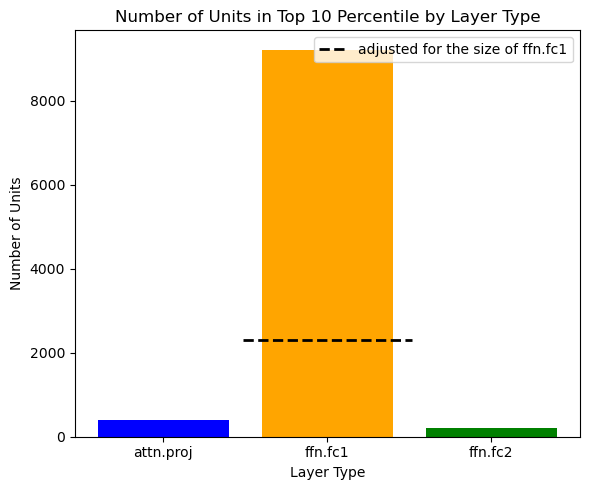

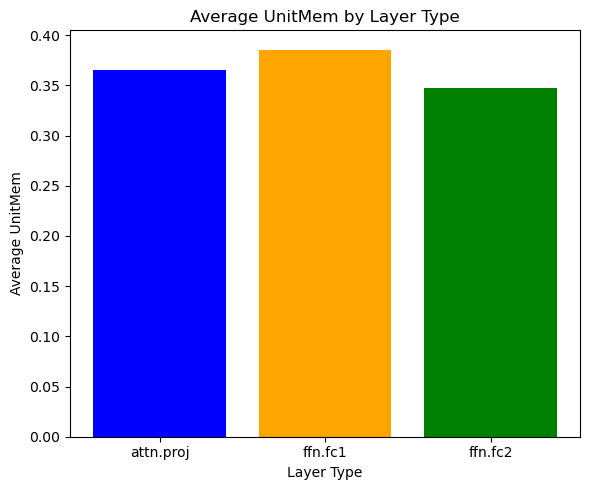

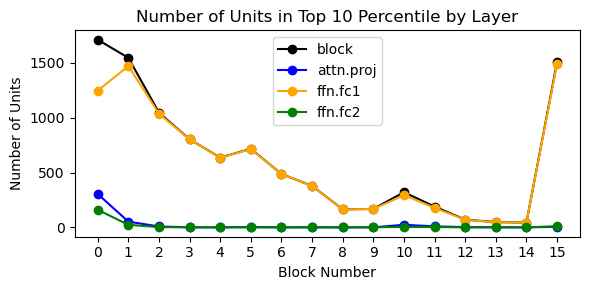

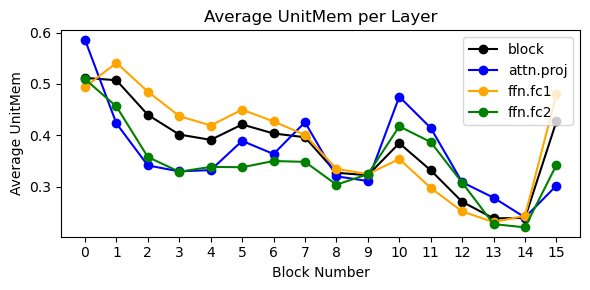

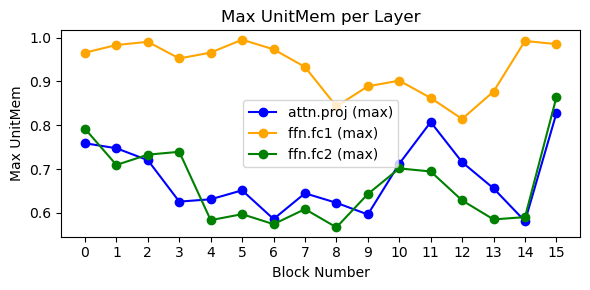

In [59]:
# Average avg_unit_mem for each layer_num, weighting 'ffn.fc1' 4 times
weighted = agg_data.copy()
weighted['weight'] = weighted['layer_type'].apply(lambda x: 4 if x == 'ffn.fc1' else 1)
block_df = weighted.groupby('layer_num', group_keys=False).apply(
    lambda g: pd.Series({
        "weighted_avg_unit_mem": np.average(g['avg_unit_mem'], weights=g['weight']),
        "sum_top_10_percentile_count": np.sum(g['top_10_percentile_count']),
    })
).reset_index()
type_df = agg_data.groupby('layer_type', group_keys=False).apply(
    lambda g: pd.Series({
        "avg_avg_unit_mem": np.average(g['avg_unit_mem']),
        "sum_top_10_percentile_count": np.sum(g['top_10_percentile_count']),
    })
).reset_index()


# First plot: Number of Units in Top 10 Percentile by Layer Type
plt.figure(figsize=(6, 5))
plt.bar(type_df['layer_type'], type_df['sum_top_10_percentile_count'], color=['blue', 'orange', 'green'])
ffn_fc1_val = type_df[type_df['layer_type'] == 'ffn.fc1']['sum_top_10_percentile_count'].values[0]
plt.axhline(ffn_fc1_val / 4, color='black', linestyle='--', linewidth=2,
            xmin=1/3, xmax=2/3,
            label='adjusted for the size of ffn.fc1')
plt.title('Number of Units in Top 10 Percentile by Layer Type')
plt.xlabel('Layer Type')
plt.ylabel('Number of Units')
plt.legend()
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_units_per_layer_type.pdf')
plt.show()

# Second plot: Average UnitMem by Layer Type
plt.figure(figsize=(6, 5))
plt.bar(type_df['layer_type'], type_df['avg_avg_unit_mem'], color=['blue', 'orange', 'green'])
plt.title('Average UnitMem by Layer Type')
plt.xlabel('Layer Type')
plt.ylabel('Average UnitMem')
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_avg_per_layer_type.pdf')
plt.show()

attn_proj_filter = agg_data['layer_type'] == 'attn.proj'
ffn_fc1_filter = agg_data['layer_type'] == 'ffn.fc1'
ffn_fc2_filter = agg_data['layer_type'] == 'ffn.fc2'


plt.figure(figsize=(6, 3))
plt.plot(block_df['layer_num'], block_df['sum_top_10_percentile_count'], label='block', marker='o', color='black')
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['top_10_percentile_count'][attn_proj_filter], label='attn.proj', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['top_10_percentile_count'][ffn_fc1_filter], label='ffn.fc1', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['top_10_percentile_count'][ffn_fc2_filter], label='ffn.fc2', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Number of Units in Top 10 Percentile by Layer')
plt.xlabel('Block Number')
plt.ylabel('Number of Units')
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_units_per_layer_num.pdf')
plt.show()

# Line plot of avg_unit_mem per layer
plt.figure(figsize=(6, 3))
plt.plot(block_df['layer_num'], block_df['weighted_avg_unit_mem'], label='block', marker='o', color='black')
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['avg_unit_mem'][attn_proj_filter], label='attn.proj', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['avg_unit_mem'][ffn_fc1_filter], label='ffn.fc1', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['avg_unit_mem'][ffn_fc2_filter], label='ffn.fc2', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Average UnitMem per Layer')
plt.xlabel('Block Number')
plt.ylabel('Average UnitMem')
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_avg_per_layer_num.pdf')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(agg_data['layer_num'][attn_proj_filter], agg_data['max_unit_mem'][attn_proj_filter], label='attn.proj (max)', marker='o', color='blue')
plt.plot(agg_data['layer_num'][ffn_fc1_filter], agg_data['max_unit_mem'][ffn_fc1_filter], label='ffn.fc1 (max)', marker='o', color='orange')
plt.plot(agg_data['layer_num'][ffn_fc2_filter], agg_data['max_unit_mem'][ffn_fc2_filter], label='ffn.fc2 (max)', marker='o', color='green')
plt.legend()
plt.xticks(range(agg_data['layer_num'].min(), agg_data['layer_num'].max()+1))
plt.title('Max UnitMem per Layer')
plt.xlabel('Block Number')
plt.ylabel('Max UnitMem')
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_max_per_layer_num.pdf')
plt.show()

Layer Num: 0
Layer: 0, top 10 indices in unit_mem: [ 915 2080 3648 3055  710 1833 2652 2550 1076 1499], values: [np.float32(0.96571887), np.float32(0.962423), np.float32(0.9583657), np.float32(0.9581004), np.float32(0.957787), np.float32(0.9570391), np.float32(0.95540977), np.float32(0.9542531), np.float32(0.9505642), np.float32(0.94970196)]
Layer Num: 5
Layer: 5, top 10 indices in unit_mem: [1772  274 3753 3867 2882 2569 1465   88 1044 3206], values: [np.float32(0.99522144), np.float32(0.96862835), np.float32(0.95164657), np.float32(0.93981194), np.float32(0.9257808), np.float32(0.92556983), np.float32(0.9203212), np.float32(0.91949224), np.float32(0.91703033), np.float32(0.916981)]
Layer Num: 10
Layer: 10, top 10 indices in unit_mem: [3959  793 3095   35  544  212 3318 3983 1113 3255], values: [np.float32(0.9017839), np.float32(0.8930637), np.float32(0.88799083), np.float32(0.8765749), np.float32(0.8555244), np.float32(0.85073), np.float32(0.8476503), np.float32(0.8471979), np.float3

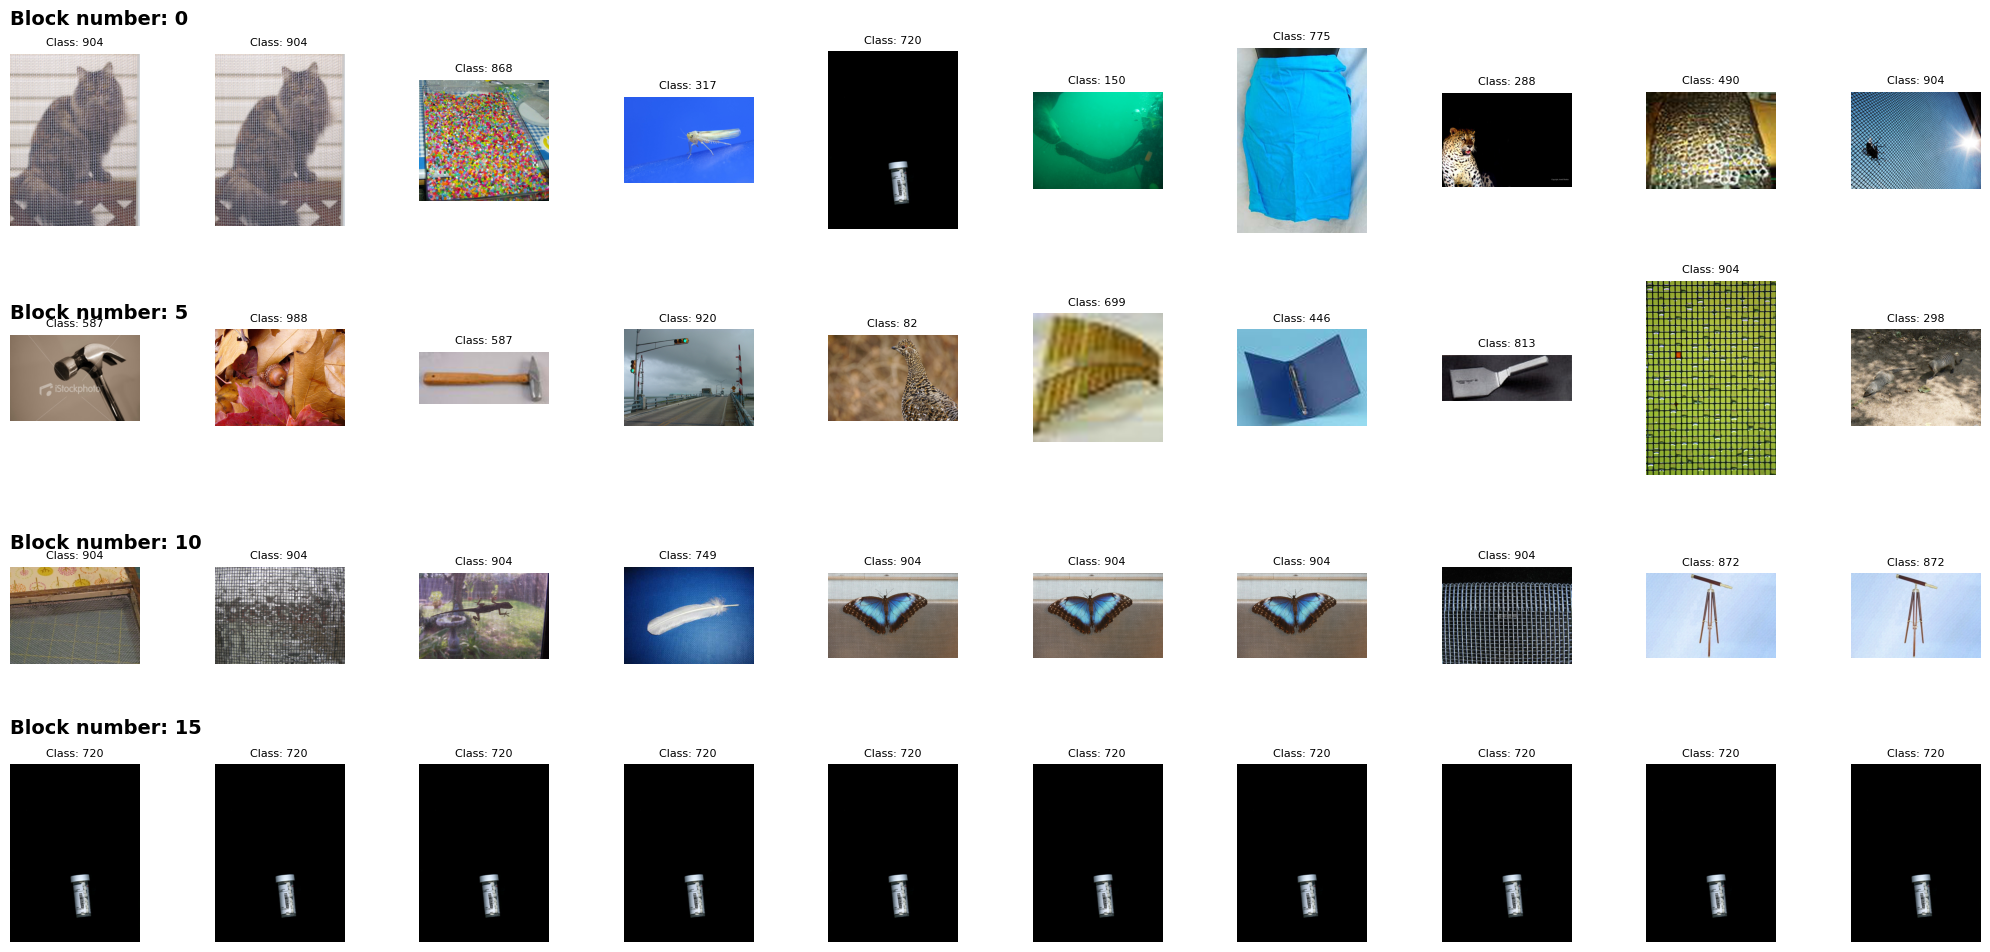

In [56]:
layer_nums = [0, 5, 10, 15]
num_top = 10
fig, axs = plt.subplots(len(layer_nums), num_top, figsize=(num_top*2, (1+len(layer_nums))*2))
for row_num, layer_num in enumerate(layer_nums):
    print(f"Layer Num: {layer_num}")
    row = agg_data[(agg_data['layer_num'] == layer_num) & (agg_data['layer_type'] == 'ffn.fc1')].iloc[0]
    unit_mem = row['unit_mem']
    max_in_type = np.argsort(unit_mem)[-num_top:][::-1]
    print(f"Layer: {layer_num}, top {num_top} indices in unit_mem: {max_in_type}, values: {[unit_mem[i] for i in max_in_type]}")
    image_indices = row['mu_argmax'][max_in_type]
    images = [ds_by_index[i] for i in image_indices]

    axs[row_num, 0].annotate(f"Block number: {layer_num}", xy=(0, 1.15), xycoords='axes fraction',
                             fontsize=14, ha='left', va='bottom', fontweight='bold')
    for idx in range(num_top):
        img, label = images[idx]
        img = img.permute(1, 2, 0).cpu().numpy()
        axs[row_num, idx].imshow((img + 1) / 2.)
        
        axs[row_num, idx].axis('off')
        axs[row_num, idx].set_title(f"Class: {label}", fontsize=8)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'mem_samples_per_layer.pdf')
plt.show()

In [60]:
activation_df_val2 = activation_df_val.copy()
data_to_agg = pd.concat([activation_df, activation_df_val], ignore_index=True)
img_cnt = num_classes * num_per_class * 2

agg_data = aggregate_data(data_to_agg, img_cnt)
agg_data

,layer_name,normal_mean,mu_mean_no_max,count,mu_max,mu_argmax,unit_mem,avg_unit_mem,max_unit_mem,layer_type,layer_num,top_10_percentile_mask,top_10_percentile_values,top_10_percentile_count,top_10_percentile_mu_argmax
layer_name,,,,,,,,,,,,,,,
blocks.00.attn.proj,blocks.00.attn.proj,"[0.10508262366056442, 0.14380186796188354, 0.1...","[0.1050571, 0.14375868, 0.17598203, 0.13309489...",16384,"[0.52330875, 0.8512874, 0.8604523, 0.59596074,...","[15434, 11582, 15553, 7385, 6003, 5876, 3947, ...","[0.66561806, 0.71105117, 0.6604088, 0.6348841,...",0.601787,0.784633,attn.proj,0,"[True, True, False, False, True, False, False,...","[0.66561806, 0.71105117, 0.6947411, 0.692931, ...",282,"[15434, 11582, 6003, 11833, 7390, 3725, 6542, ..."
blocks.00.ffn.fc1,blocks.00.ffn.fc1,"[0.11942267417907715, 0.026731567457318306, 0....","[0.11941265, 0.026680823, 0.027278349, 0.02679...",16384,"[0.28359884, 0.85805017, 0.08614508, 0.0609860...","[13769, 12101, 2579, 7371, 5488, 12187, 12987,...","[0.40739825, 0.939686, 0.51899976, 0.38957214,...",0.510709,0.981754,ffn.fc1,0,"[False, True, False, False, False, False, True...","[0.939686, 0.7523373, 0.72405636, 0.7122161, 0...",1254,"[12101, 12987, 15869, 8380, 12131, 5488, 13852..."
blocks.00.ffn.fc2,blocks.00.ffn.fc2,"[0.1549641638994217, 0.17299164831638336, 0.31...","[0.15493664, 0.1729646, 0.31634057, 0.15713519...",16384,"[0.60589236, 0.61593795, 1.2292998, 0.51427364...","[15866, 9265, 5859, 15558, 5515, 12254, 3335, ...","[0.5927163, 0.5615058, 0.5906673, 0.53192395, ...",0.537170,0.808034,ffn.fc2,0,"[False, False, False, False, False, False, Fal...","[0.7335351, 0.7008021, 0.7706334, 0.67610073, ...",191,"[13769, 15565, 15565, 15565, 15578, 6870, 1555..."
blocks.01.attn.proj,blocks.01.attn.proj,"[0.12624327838420868, 0.12397927790880203, 0.1...","[0.12623328, 0.12396904, 0.13870978, 0.1275106...",16384,"[0.2899906, 0.29176763, 0.45769754, 0.3339557,...","[8025, 15218, 15569, 15361, 14179, 1400, 7426,...","[0.3934357, 0.40361744, 0.53484887, 0.44736755...",0.442628,0.747997,attn.proj,1,"[False, False, False, False, False, False, Fal...","[0.7145623, 0.67062855, 0.7054877, 0.70801944,...",47,"[12254, 641, 11375, 622, 13769, 11222, 15578, ..."
blocks.01.ffn.fc1,blocks.01.ffn.fc1,"[0.1345120072364807, 0.16494177281856537, 0.12...","[0.13444689, 0.16493076, 0.12326357, 0.1106691...",16384,"[1.2013267, 0.34554553, 0.6270267, 0.41124493,...","[16036, 4798, 15908, 11370, 8961, 7161, 8128, ...","[0.7986981, 0.35381618, 0.67142427, 0.5759105,...",0.559529,0.983102,ffn.fc1,1,"[True, False, True, False, False, False, True,...","[0.7986981, 0.67142427, 0.9080569, 0.8614084, ...",1464,"[16036, 15908, 8128, 11778, 7545, 4062, 6178, ..."
blocks.01.ffn.fc2,blocks.01.ffn.fc2,"[0.18882304430007935, 0.18963228166103363, 0.2...","[0.18880504, 0.18960968, 0.26604146, 0.1877703...",16384,"[0.48365203, 0.5600735, 0.7179813, 0.6562122, ...","[3624, 7386, 6496, 3725, 11833, 1218, 875, 752...","[0.43846214, 0.49416053, 0.45927784, 0.5550374...",0.478540,0.709583,ffn.fc2,1,"[False, False, False, False, False, False, Fal...","[0.6811395, 0.668697, 0.7088654, 0.66909134, 0...",18,"[7385, 13769, 7385, 15569, 15565, 15565, 15565..."
blocks.02.attn.proj,blocks.02.attn.proj,"[0.1195204108953476, 0.11390694975852966, 0.12...","[0.11951557, 0.11389766, 0.123799086, 0.114228...",16384,"[0.19884267, 0.26615095, 0.24136202, 0.2433975...","[11871, 7378, 8562, 11822, 2655, 10661, 116, 8...","[0.24917561, 0.40061533, 0.3219481, 0.36118454...",0.359956,0.730465,attn.proj,2,"[False, False, False, False, False, False, Fal...","[0.70170337, 0.7262621, 0.6639587, 0.70870376,...",8,"[11822, 13769, 2096, 11822, 11822, 11218, 1376..."
blocks.02.ffn.fc1,blocks.02.ffn.fc1,"[0.13889549672603607, 0.12951190769672394, 0.1...","[0.13887718, 0.12950945, 0.14088498, 0.1254220...",16384,"[0.43892768, 0.16978145, 1.0543342, 0.17608039...","[561, 15569, 14928, 3632, 3994, 14045, 14346, ...","[0.51929384, 0.13455804, 0.7642524, 0.16801958...",0.504233

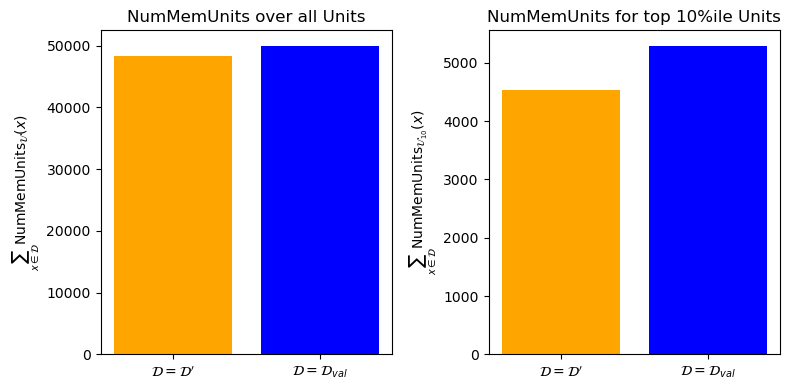

In [63]:
# Calculate counts for mu_argmax values > img_cnt//2 and <= img_cnt//2
def get_counts(df):
    count_val = 0
    count_train = 0
    for arr in df:
        arr = np.array(arr)
        count_train += np.sum(arr <= img_cnt // 2)
        count_val += np.sum(arr > img_cnt // 2)
    return count_train, count_val

count_train1, count_val1 = get_counts(agg_data['mu_argmax'])
count_train2, count_val2 = get_counts(agg_data['top_10_percentile_mu_argmax'])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].bar([r'$\mathcal{D}=\mathcal{D}^\prime$', r'$\mathcal{D}=\mathcal{D}_{val}$'],
            [count_train1, count_val1], color=['orange', 'blue'])
axs[0].set_ylabel(r'$\sum_{x\in\mathcal{D}}\text{NumMemUnits}_\mathcal{U}(x)$')
axs[0].set_title('NumMemUnits over all Units')

axs[1].bar([r'$\mathcal{D}=\mathcal{D}^\prime$', r'$\mathcal{D}=\mathcal{D}_{val}$'],
            [count_train2, count_val2], color=['orange', 'blue'])
axs[1].set_ylabel(r'$\sum_{x\in\mathcal{D}}\text{NumMemUnits}_{\mathcal{U}_{10}}(x)$')
axs[1].set_title('NumMemUnits for top 10%ile Units')

plt.tight_layout()
plt.savefig(FIGURE_PATH + 'num_mem_units_train_val.pdf')
plt.show()